# Transformer text classification

Given a corpus made for 50% of real text samples and for 50% of random strings, the goal is to classify strings of text as real or random.
For this purpose we will train a very simple transformer.

### imports

In [56]:
import random, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

In [68]:
random.seed(0)
torch.manual_seed(0)

train_dataset_path = "datasets/train_dataset_128.csv"
val_dataset_path = "datasets/val_dataset_128.csv"

BATCH_SIZE = 8
MAX_LEN = 128
LEARNING_RATE = 1e-4
EPOCHS = 5

## Dataset

In [60]:
# Simple char-level vocab builder
def build_vocab(texts, min_freq=1):
    from collections import Counter
    cnt = Counter()
    for t in texts:
        cnt.update(list(t))
    chars = [c for c,f in cnt.items() if f>=min_freq]
    vocab = {'<pad>':0, '<unk>':1}
    for i,c in enumerate(sorted(chars), start=2):
        vocab[c]=i
    return vocab

class TextDataset(Dataset):
    def __init__(self, csv_path, vocab, max_len=128):
        df = pd.read_csv(csv_path)
        self.texts = df['text'].astype(str).tolist()
        self.labels = df['label'].astype(int).tolist()
        self.vocab = vocab
        self.max_len = max_len

    def encode(self, s):
        ids = [self.vocab.get(c, self.vocab['<unk>']) for c in s][:self.max_len]
        if len(ids)<self.max_len:
            ids += [self.vocab['<pad>']]*(self.max_len-len(ids))
        return torch.tensor(ids, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.encode(self.texts[idx]), torch.tensor(self.labels[idx], dtype=torch.float32)

def collate_batch(batch):
    xs = torch.stack([b[0] for b in batch])
    ys = torch.stack([b[1] for b in batch])
    return xs, ys

In [61]:
train_df = pd.read_csv(train_dataset_path)
vocab = build_vocab(train_df['text'].astype(str).tolist())
train_ds = TextDataset(train_dataset_path, vocab, max_len=MAX_LEN)
val_ds = TextDataset(val_dataset_path, vocab, max_len=MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)


## Model

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, nhead=8, nhid=128, nlayers=2, max_len=128, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.fc = nn.Linear(emb_dim, 1)

    def forward(self, x):
        # x: (batch, seq_len)
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(x.size(0), -1)
        x = self.token_emb(x) + self.pos_emb(positions)
        # transformer expects (seq_len, batch, emb_dim)
        x = x.transpose(0,1)
        x = self.encoder(x)
        x = x.mean(dim=0)  # pooled over sequence
        logit = self.fc(x).squeeze(-1)
        return logit

## Training

In [94]:
def train_epoch(model, dl, optimizer, device):
    model.train()
    total_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(dl.dataset)

def evaluate(model, dl, device):
    model.eval()
    probs = []
    targets = []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device)
            logits = model(xb)
            p = torch.sigmoid(logits).cpu().numpy()
            probs.extend(p.tolist())
            targets.extend(yb.numpy().tolist())
    preds = [1 if p>0.5 else 0 for p in probs]
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, zero_division=0)
    rec = recall_score(targets, preds)
    f1 = f1_score(targets, preds)
    try:
        auc = roc_auc_score(targets, probs)
    except Exception:
        auc = float('nan')
    return {'accuracy': acc, 'auc': auc, 'precision': prec, 'recall': rec, 'f1': f1}

In [69]:
model = TransformerClassifier(vocab_size=len(vocab), emb_dim=128, nhead=4, nhid=256, nlayers=3, max_len=MAX_LEN).to(device)
opt = Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS+1):
    loss = train_epoch(model, train_loader, opt, device)
    metrics = evaluate(model, val_loader, device)
    print(f"Epoch {epoch}: loss={loss:.4f}, val_acc={metrics['accuracy']:.4f}, val_prec={metrics['precision']:.4f}, val_rec={metrics['recall']:.4f}, val_f1={metrics['f1']:.4f}, val_auc={metrics['auc']:.4f}")

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: loss=0.5076, val_acc=0.7560, val_prec=0.6734, val_rec=0.9940, val_f1=0.8029, val_auc=0.7858
Epoch 2: loss=0.4795, val_acc=0.7610, val_prec=0.6800, val_rec=0.9860, val_f1=0.8049, val_auc=0.8073
Epoch 2: loss=0.4795, val_acc=0.7610, val_prec=0.6800, val_rec=0.9860, val_f1=0.8049, val_auc=0.8073
Epoch 3: loss=0.4688, val_acc=0.7690, val_prec=0.6919, val_rec=0.9700, val_f1=0.8077, val_auc=0.8209
Epoch 3: loss=0.4688, val_acc=0.7690, val_prec=0.6919, val_rec=0.9700, val_f1=0.8077, val_auc=0.8209
Epoch 4: loss=0.4585, val_acc=0.7690, val_prec=0.7105, val_rec=0.9080, val_f1=0.7972, val_auc=0.8241
Epoch 4: loss=0.4585, val_acc=0.7690, val_prec=0.7105, val_rec=0.9080, val_f1=0.7972, val_auc=0.8241
Epoch 5: loss=0.4486, val_acc=0.7670, val_prec=0.6955, val_rec=0.9500, val_f1=0.8030, val_auc=0.8290
Epoch 5: loss=0.4486, val_acc=0.7670, val_prec=0.6955, val_rec=0.9500, val_f1=0.8030, val_auc=0.8290


## Inference

In [70]:
def predict(model, text):
    model.eval()
    # Use the same vocab and MAX_LEN as training
    ids = [vocab.get(c, vocab['<unk>']) for c in text][:MAX_LEN]
    if len(ids) < MAX_LEN:
        ids += [vocab['<pad>']] * (MAX_LEN - len(ids))
    x = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        logit = model(x)
        prob = torch.sigmoid(logit).item()
    return prob  # Probability that text is random (label==1)

In [73]:
print(predict(model, "This is a sample of real text (pretty much)."))  # Expected: close to 1
print(predict(model, "afdgfg gfdasnl dfalkad "))  # Expected: close to 0

0.8855978846549988
0.8990936875343323


## Adversarial attack

In [90]:
def random_uniform_like(n):
    """Uniform random characters."""
    chars = string.ascii_lowercase + "   "
    return ''.join(random.choice(chars) for _ in range(n))


def random_markov_like(n):
    """Produce pseudo-word sequences that look a bit structured but are gibberish."""
    consonants = "bcdfghjklmnpqrstvwxyz  "
    vowels = "aeiou  "
    s = ""
    for _ in range(n):
        pattern = random.choice([
            random.choice(consonants),
            random.choice(vowels),
            random.choice(consonants) + random.choice(vowels),
            random.choice(vowels) + random.choice(consonants)
        ])
        s += pattern
    return s[:n]

def adversarial_attack(model, max_ite=200, samples=10, plot=True):
    scores_history = np.zeros((len(range(10,MAX_LEN+1,50)), samples, max_ite))
    j = 0
    for n in range(10,MAX_LEN+1,50):
        for e in range(samples//2):
            rand_seq = random_uniform_like(n)
            score = predict(model, rand_seq)

            for i in range(max_ite):
                chars = "bcdfghjklmnpqrstvwxyz aeiou "
                pos = random.randint(0, len(rand_seq)-1)
                new_char = random.choice(chars)
                new_seq = rand_seq[:pos] + new_char + rand_seq[pos+1:]
                new_score = predict(model, new_seq)
                if new_score > score:
                    rand_seq = new_seq
                    score = new_score
                scores_history[j, e, i] = score
        for e in range(samples//2):
            rand_seq = random_markov_like(n)
            score = predict(model, rand_seq)

            for i in range(max_ite):
                chars = "bcdfghjklmnpqrstvwxyz aeiou "
                pos = random.randint(0, len(rand_seq)-1)
                new_char = random.choice(chars)
                new_seq = rand_seq[:pos] + new_char + rand_seq[pos+1:]
                new_score = predict(model, new_seq)
                if new_score > score:
                    rand_seq = new_seq
                    score = new_score
                scores_history[j, e+samples//2, i] = score

        if plot:
            plt.figure(figsize=(4, 3))
            plt.plot(scores_history[j].T)
            # color the area where the string wolud get recognized as real (0.5 threshold)
            plt.fill_between(range(scores_history.shape[2]), 0.5, 1, color='red', alpha=0.2)
            plt.xlabel("Iteration")
            plt.ylabel("Predicted Real Text Score")
            plt.title(f"Evolution of Random Sequence Scores for n={n}")
            plt.show()
        
        j+=1
    return scores_history

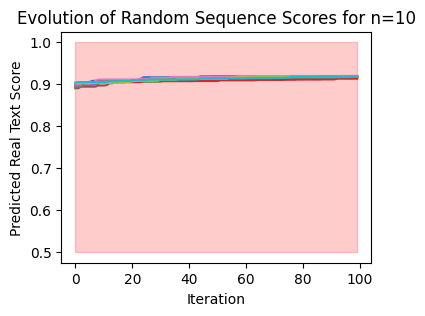

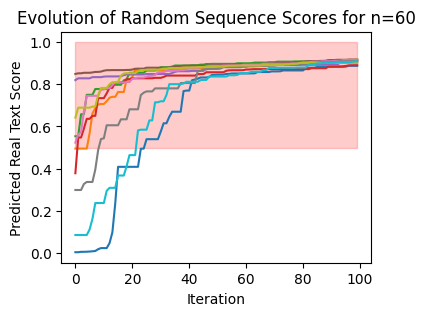

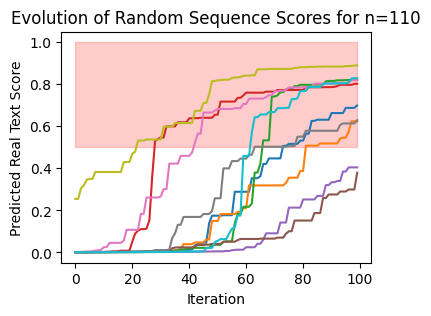

In [95]:
h = adversarial_attack(model, max_ite=100, samples=10, plot=True)

In [96]:
print("Adv @10: ", np.sum(h[0, :, -1] >= 0.5)/len(h[0, :, -1]))
print("Adv @60: ", np.sum(h[1, :, -1] >= 0.5)/len(h[0, :, -1]))
print("Adv @110: ", np.sum(h[2, :, -1] >= 0.5)/len(h[0, :, -1]))

Adv @10:  1.0
Adv @60:  1.0
Adv @110:  0.8
